In [23]:
# Import deep learning (tensorflow.keras) and relevant pyhthon libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
# Classification metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import cohen_kappa_score
# Keras
import tensorflow as tf
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
# Ignore ConvergenceWarning messages
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [24]:
def train_application():
        
    """
    This function reads application_train.csv table, cleans it, and perform manual feature engineering for each
    application (SK_ID_CURR).   
    
    Parameters:
    None

    Returns:
    train: train DataFrame which includes hand engineered features from application_train table.   
    
    """
    
    print('Processing application_train table')
    train = pd.read_csv('application_train.csv')
    # Delete four applications with XNA CODE_GENDER (train set)
    train = train[train['CODE_GENDER'] != 'XNA']
    # Replace DAYS_EMPLOYED = 365243 by nan
    train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True) 
    # Feature engineering
    train['Days_employed_age']   = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
    train['Credit_income_ratio'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
    train['Anuity_income_ratio'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL'] 
    train['Income_per_person']   = train['AMT_INCOME_TOTAL'] / train['CNT_FAM_MEMBERS']
    #length of the payment in months since the annuity is the monthly amount due
    train['Credit_term'] = train['AMT_ANNUITY']/train['AMT_CREDIT'] 
    
    return train

In [25]:
def bureau_RNN_features(train, nrows):
    ''' 
    Recurrent Neural Network (RNN) is used to extract new feture from sequential historical data,
    Customer journey information based on Bureau table.
    
    Parameters:
    train: preprocessed training data 
    nrows: number of rows considered in train data for the model due to the computational power limitation.

    Returns:
    train: train dataframe with added new features from applying RNN on the bureau table. 
    '''
    print('Extracting features using Recurrent Neural Network (RNN) ...')
    train = train[:nrows]
    idl = train['SK_ID_CURR'].values
    bureau = pd.read_csv('bureau.csv')
    # Imputating the missing data in bureau table
    # Missing categorical features are imputed with 'Not_applicable'
    # Missing numeric features are imputed with Zero (logical choice for this dataset)
    cols = bureau.select_dtypes(include = object).columns
    bureau [cols] = bureau[cols].fillna('Not_Applicable')
    cols = bureau.select_dtypes(exclude = object).columns
    bureau[cols] = bureau[cols].fillna(0)

    # One-hot encoding of categorical features
    bureau = pd.get_dummies(bureau, drop_first= True)
    bureau = bureau.sort_values('DAYS_CREDIT', ascending= False)
    lst = bureau['SK_ID_CURR'].values
    lst = list(set(lst))
    lst.sort()

    # Making bureau table data structure similar to an image
    # Applications are grouoped by SK_ID_CURR and for each SK_ID_CURR, the 5 most recent SK_ID_BUREAU is considered.
    # If an SK_ID_CURR did not have 5 records, empty rows were added and filled with -99 (to avoid confusion with zero). 
    group = bureau.groupby('SK_ID_CURR')
    b = [] # b is the reshaped data structure of bureau table, suitable for use in RNN
    j=0
    for sk in idl:
        if sk in lst:
            a = group.get_group(lst[j])
            if a.shape[0] >= 5:
                a = a[:5]
            else:
                # m99 represents rows having value of -99
                m99 = np.ones((5-a.shape[0],a.shape[1]))*-99
                m99 = pd.DataFrame(m99, columns=a.columns)
                a   = a.append(m99)
            a = a.drop(['SK_ID_CURR', 'SK_ID_BUREAU'], axis=1)    
            a = a.values.flatten().tolist()
            b.extend(a)
            j += 1
        else:
            m99 = np.ones((5,bureau.shape[1]))*-99
            m99 = pd.DataFrame(m99, columns=bureau.columns)
            m99 = m99.drop(['SK_ID_CURR', 'SK_ID_BUREAU'], axis=1)    
            m99 = m99.values.flatten().tolist()
            b.extend(m99)
    b = np.array(b)
    b = np.reshape(b,(idl.shape[0], 5, bureau.shape[1]-2))
    print('shape of channel(bureau):', b.shape)
    y = train['TARGET']
    y = to_categorical(y,2)    

    # Deep RNN implementation
    # RNN architecture includes 2 Long Short Term Memory (LSTM) units followed by two fully connected layer
    batch_size = 256
    epochs = 100
    np.random.seed(5)        

    model = Sequential()

    #1st LSTM layer
    model.add(LSTM(units = 50, input_shape=(b.shape[1],b.shape[2]), return_sequences= True))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.2))

    #2nd LSTM layer
    model.add(LSTM(50, return_sequences= True))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Flatten())

    #FC1
    model.add(Dense(units= 128))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.5))

    #FC2
    model.add(Dense(units= 100, name= 'RNN_feature_extract'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    #output FC
    model.add(Dense(units= 2, activation='sigmoid'))
    model.build()
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['AUC'])
    model.summary()

    # Train deep neural network
    early_stops = EarlyStopping(patience=5, monitor='val_auc')
    mc = ModelCheckpoint('best_model.h5',
                          monitor='val_loss', 
                          verbose=0, 
                          save_best_only=True)
    model.fit(b, y, validation_split=0.05, callbacks=[early_stops, mc], batch_size= batch_size, epochs= epochs, verbose=1)

    # Extract the useful featuer from RNN after training the deep nerual network
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('RNN_feature_extract').output)
    intermediate_layer_model.summary()

    #predict to get featured data
    feauture_engg_data = intermediate_layer_model.predict(b)
    feauture_engg_data = pd.DataFrame(feauture_engg_data)
    print('feauture_engg_data shape:', feauture_engg_data.shape)
    
    # Renaming columns
    new_col = []
    for i in range(100):
        new_col.append('bfeat_%d'%(i+1))
    feauture_engg_data.columns = new_col
    feauture_engg_data['SK_ID_CURR'] = idl

    # Merge RNN features to train dataset
    train = train.merge(feauture_engg_data, on='SK_ID_CURR', how='left')
    
    return train

In [26]:
def preprocessing(train):
    '''
    This function calculates the correlation between all features in training data and drops the columns with 
    correlation > 0.98.

    Parameters:
    train: train set

    Returns:
    train: pandas.DataFrame which includes preprocessed training data.
    
    '''
    print('Preprocessing final table and label encoding categorical features...')

    # Drop the columns with correlation > -0.98
    corr = train.corr()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
    train = train.drop(to_drop, axis=1)

    # Encoding categorical features because lightGBM offers good accuracy with integer-encoded categorical features. 
    class_le = LabelEncoder()
    cols = train.select_dtypes(include= object).columns
    for col in cols:
        train[col] = class_le.fit_transform(train[col].values.astype(str))
        train[col] = train[col].astype('category')

    return train

In [27]:
def lightGBM(train,num_folds, test_size):
    
    '''
    This function trains a machine learning model using LightGBM algorithm. 

    Parameters:
    train: preprocessed dataframe with added RNN features
    num_folds: number of folds for cross-validation (default is 5)
    test_size: ratio of test to train in the training dataset

    Returns:
    pred_class: Binary class prediction of the target variable.
    pred: Probability prediction of the target variable.
    y_test: y_test in the trainig dataset
    '''
    print('Applying LightGBM algorithm...')
    y = train['TARGET']
    X = train.drop('TARGET', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = test_size, random_state=1234)
    # Lighgbm parameters was found using Bayesian Optimization
    model_params = {
      'colsample_bytree': 0.45544541538547634,
      'learning_rate': 0.09712737568777673,
      'max_depth': 10,
      'min_child_weight': 44.81416318834993,
      'min_split_gain': 0.47913323843650946,
      'num_leaves': 44,
      'reg_alpha': 8.507126649843658,
      'reg_lambda': 2.2113739093853257,
      'subsample': 0.43342993037373423
    }
    model = make_pipeline(StandardScaler(), LGBMClassifier(**model_params))
    # cross validation scores
    scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=num_folds, n_jobs=-1, verbose = 100)
    print('max cross_val AUC: ', np.max(scores))
    model.fit(X_train, y_train)
    # Binary class prediction
    pred_class = model.predict(X_test)
    # Probability prediction
    pred = model.predict_proba(X_test)
    pred = [p[1] for p in pred]
    return pred_class, pred, y_test

In [28]:
def calculate_metrics(pred_class, pred, y_test):
    
    '''
    This function calculates the classificaiton metrics including precision, recall, F1-Score, AUC_ROC, and cohen-kappa coefficient.

    Parameters:
    pred_class: Binary class prediction of the target variable.
    pred: Probability prediction of the target variable.
    y_test: y_test in the trainig dataset

    Returns:
    None
    '''
    
    # ROC_AUC score
    print('ROC_AUC:', roc_auc_score(y_test, pred))
    # Precision/Recall (0.1 Threshold)
    pred_class_2 = (np.array(pred) > 0.1).astype(int)
    cm = confusion_matrix(y_test, pred_class_2)
    print('\nConfusion_metrix (0.1 Threshold): \n', cm)
    # True Negatives (TN)
    tn = cm[0][0]
    # False Positives (FP)
    fp = cm[0][1]    
    # False Negatives (FN)
    fn = cm[1][0]
    # True Positives (TP)
    tp = cm[1][1]
    precision = tp / (tp + fp)
    print( 'Precision (0.1 Threshold): ', precision )
    recall = tp / (tp + fn)
    print( 'Recall (0.1 Threshold): ', recall )
    print( 'F1-score ( 0.1 Threshold):', 2*precision*recall/(precision+recall))
    cohen_kappa = cohen_kappa_score(y_test, pred_class_2)
    print( '\nCohen_kappa (0.1 Threshold): ', cohen_kappa )

def plot_ROC(y_test, pred):
    '''
    This function plots ROC based on y_test and predictied probability of positive class by lightGBM.

    Parameters:
    pred: Probability prediction of the target variable.
    y_test: y_test in the trainig dataset

    Returns:
    None
    '''
    # Initialize figure
    fig = plt.figure(figsize=(9,9))
    plt.title('Receiver Operating Characteristic')
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    plt.plot(fpr, tpr)
    # Diagonal 45 degree line
    plt.plot([0,1],[0,1],'k--')
    # Axes limits and labels
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def plot_precision_recall(y_test, pred):
    '''
    This function plots precicision_recall curve based on y_test and predictied probability of positive class by lightGBM..

    Parameters:
    pred: Probability prediction of the target variable.
    y_test: y_test in the trainig dataset
    
    Returns:
    None
    '''
    precision, recall, thresholds = precision_recall_curve(y_test, pred)
    fig = plt.figure(figsize=(9,9))
    plt.title('Precision_Recall')
    # Plot Precision-Recall curve
    plt.plot(recall, precision)
    # Axes limits and labels
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()

Processing application_train table
Extracting features using Recurrent Neural Network (RNN) ...
shape of channel(bureau): (30000, 5, 32)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5, 50)             16600     
_________________________________________________________________
batch_normalization_12 (Batc (None, 5, 50)             200       
_________________________________________________________________
activation_12 (Activation)   (None, 5, 50)             0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
batch_normalization_13 (Batc (None, 5, 50)       

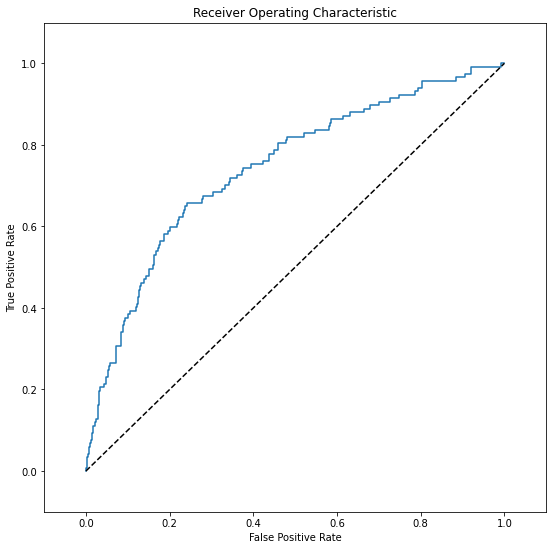

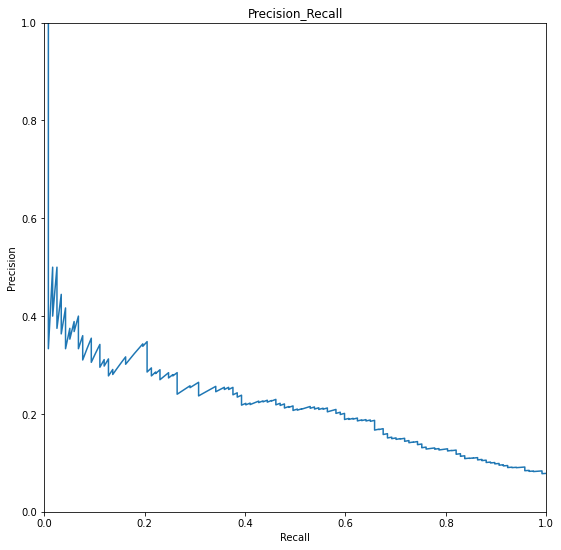

In [29]:
''' -------------------------------Main---------------------------
The main calls all funcitons sequentillay, merge the tables, train lightGBM, and plot the classification metrics.

LGBM performance is compared in two following considitons: 
    1) training data with concatenated RNN features 
    2) training data without RNN features.
    
'''
# nrows: number of rows considered in train data for the model due to the computational power limitation.
nrows = 30000

# 1) Model performance with concatenating RNN features
train = train_application()
# Extract new features using RNN
train = bureau_RNN_features(train, nrows)
# Preprocesing including label encoding of categorical varibles for LightGBM 
train = preprocessing(train)
# Training LightGBM
nfolds = 5 # number of folds for cross-validation (default is 5)
test_size = 0.05 # ratio of test to train dataset
pred_class, pred, y_test = lightGBM(train, nfolds, test_size)
# Evalutate ROC_AUC, Precision, Recall, F1-Score, Kohen-Cappa metrics
calculate_metrics(pred_class, pred, y_test)
# Plot ROC curve
plot_ROC(y_test, pred)
# Plot Precision/R curve
plot_precision_recall(y_test, pred)

Processing application_train table
Preprocessing final table and label encoding categorical features...
Applying LightGBM algorithm...
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished
max cross_val AUC:  0.7641773902141481
ROC_AUC: 0.7366928082763224

Confusion_metrix (0.1 Threshold): 
 [[1102  281]
 [  50   67]]
Precision (0.1 Threshold):  0.1925287356321839
Recall (0.1 Threshold):  0.5726495726495726
F1-score ( 0.1 Threshold): 0.28817204301075267

Cohen_kappa (0.1 Threshold):  0.19408247141549306


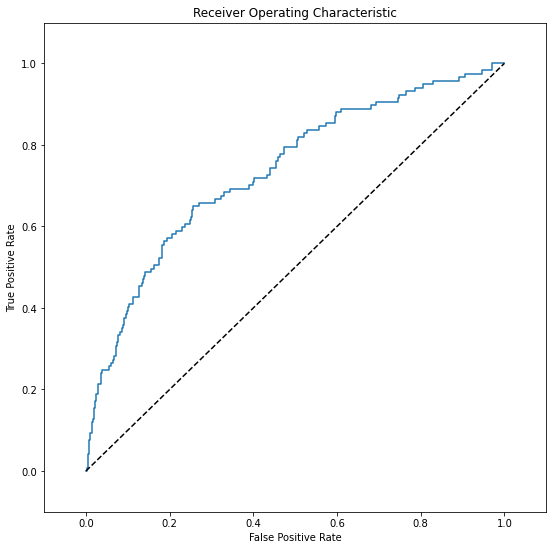

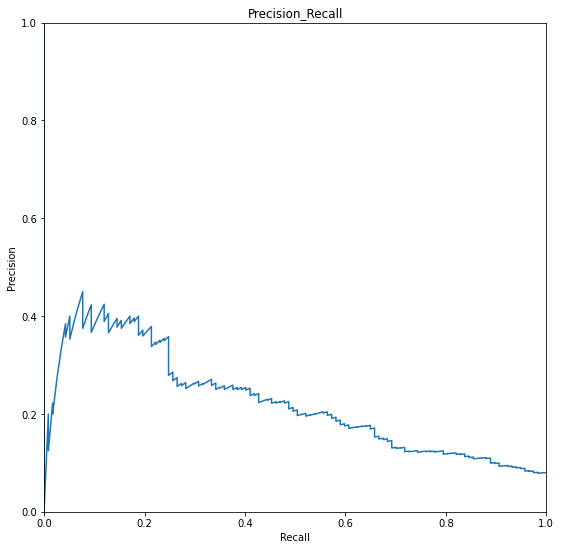

In [31]:
# 2) Model performance without RNN features
train = train_application()
train= train[:nrows]
# Preprocesing including label encoding of categorical varibles for LightGBM 
train = preprocessing(train)
train = train[:nrows]
# Training LightGBM
nfolds = 5
test_size = 0.05
pred_class, pred, y_test = lightGBM(train, nfolds, test_size)
# Evalutate ROC_AUC, Precision, Recall, F1-Score, Kohen-Cappa metrics
calculate_metrics(pred_class, pred, y_test)
# Plot ROC curve
plot_ROC(y_test, pred)
# Plot Precision/R curve
plot_precision_recall(y_test, pred)